# First experiment
Try to let the network learn the flow by using the warped labels as error. In the following we also test, which of the two feature extractors works better for this specific problem. On the one hand, we have the obelisk feature extractor and on the other hand, we have a simple sequential CNN. both have their pros and cons, regarding runtime and used resources.

Current state of the notebook is after results completion. There have been slight changes to the intial setup. 

In [1]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage #, correlation_layer, meanfield
from utils.encoding import labelMatrixOneHot, dice_coeff


from models.pdd_net.pdd_student import OBELISK2d, deeds2d

import warnings
warnings.filterwarnings('ignore')

mode='label loss'

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7f88c732fe80>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [2]:
def update_sheet(epochs, optim, loss,grad_accum,lr, mode, eval_mean_dice, unwarped_dice, notes):
    """
    function to update a csv table to keep track of results
    """
    df = pd.read_csv('experiments.csv')
    df = df.drop('Unnamed: 0', axis=1)
    df = df.append({
        'epochs':epochs,
        'optim':optim,
        'batch size': grad_accum,
        'learning rate': lr,
        'loss':loss,
        'mode': mode,
        'Eval mean dice': eval_mean_dice,
        'unwarped dice': unwarped_dice,
        'time': datetime.now().strftime("%d.%m.%y %H:%M"),
        'notes': notes
    }, ignore_index=True)
    df.to_csv('experiments.csv')
    print('updated')

# Data

In [3]:
#imgs1 = torch.load('/share/data_ultraschall/nicke_ma/data/train_frames.pth')
#segs1 = torch.load('/share/data_ultraschall/nicke_ma/data/train_segs.pth')

imgs2 = torch.load('/share/data_ultraschall/nicke_ma/data/train_frames_disp_6.pth')
segs2 = torch.load('/share/data_ultraschall/nicke_ma/data/train_segs_disp_6.pth')

imgs3 = torch.load('/share/data_ultraschall/nicke_ma/data/frames_oneFixed_multipleMoving_dist2.pth')
segs3 = torch.load('/share/data_ultraschall/nicke_ma/data/segs_oneFixed_multipleMoving_dist2.pth')

In [4]:
# use both data sets
imgs = torch.cat((imgs2,imgs3))
segs = torch.cat((segs2,segs3))

In [5]:
#define a training split 
torch.manual_seed(42)
# Now, we prepare our train & test dataset.
train_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.95), replace=False))

test_set = torch.arange(len(imgs))
for idx in train_set:
    test_set = test_set[test_set != idx]

#for i, seg in enumerate(segs):
#    f_seg = seg[0]
#    m_seg = seg[1]
#    if len(torch.where(torch.histc(f_seg) != 0)[0]) == 3 and f_seg.max() < 1:
#        print('here')
#        segs[i][0] = segs[i][0]*2 
#    if len(torch.where(torch.histc(m_seg) != 0)[0]) == 3 and m_seg.max() < 1:
#        segs[i][1] = segs[i][1]*2 

print(f"{train_set.shape[0]} train examples")
print(f"{test_set.shape[0]} test examples")

2519 train examples
133 test examples


# Networks
        

In [6]:
class OBELISK2d(nn.Module):
    def __init__(self, chan=16, size=(150,150)):
        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2, channels * 2, 2) * 0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels * 8, channels * 4, 1, bias=False,
                                groups=1)
        self.batch1 = nn.BatchNorm2d(channels * 4)
        self.layer2 = nn.Conv2d(channels * 4, channels * 4, 3, bias=False,
                                padding=1)
        self.batch2 = nn.BatchNorm2d(channels * 4)
        self.layer3 = nn.Conv2d(channels * 4, channels * 1, 1)

        H = size[0]
        W = size[1]
        self.o_m = H // 4 +1
        self.o_n = W // 4 +1

        self.displace_range = 11
        self.disp_hw = 5
        self.ogrid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                 (1, 1, self.o_m, self.o_n)).view(1, 1, -1, 2).cuda()
        self.disp_range = 0.25
        self.displacement_width = 11
        shift_xy = F.affine_grid(self.disp_range * torch.eye(2, 3).unsqueeze(0), (1, 1, self.displacement_width, self.displacement_width)).view(1, 1, -1, 2).cuda()
        grid_size = 32  # 25#30
        self.grid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                (1, 1, grid_size, grid_size)).view(1, -1, 1,
                                                                   2).cuda()

    def forward(self, fixed_img, moving_img):
        img_in_f = F.avg_pool2d(fixed_img, 3, padding=1, stride=2)
        img_in_f = F.relu(self.batch0(self.layer0(img_in_f)))
        sampled_f = F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_f -= F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_1 = F.relu(self.batch1(self.layer1(sampled_f)))
        x_1 = F.relu(self.batch2(self.layer2(x_1)))
        features_fixed = self.layer3(x_1)
        
        img_in_m = F.avg_pool2d(moving_img, 3, padding=1, stride=2)
        img_in_m = F.relu(self.batch0(self.layer0(img_in_m)))
        sampled_m = F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_m -= F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_2 = F.relu(self.batch1(self.layer1(sampled_m)))
        x_2 = F.relu(self.batch2(self.layer2(x_2)))
        features_moving = self.layer3(x_2)

        ssd_distance = self.correlation_layer(features_moving, features_fixed)
        soft_cost,disp_xy = self.meanfield(ssd_distance, fixed_img, self.displace_range, self.o_m, self.o_n)
        
        return soft_cost, disp_xy


    def min_convolution(self, ssd_distance, displace_range, H, W):
        # Prepare operators for smooth dense displacement space
        pad1 = nn.ReplicationPad2d(5)
        avg1 = nn.AvgPool2d(5, stride=1)
        max1 = nn.MaxPool2d(3, stride=1)
        pad2 = nn.ReplicationPad2d(4)
        # approximate min convolution / displacement compatibility

        ssd_minconv = avg1(avg1(-max1(-pad1(
            ssd_distance.permute(0, 2, 3, 1).reshape(1, -1, self.displace_range,
                                                    self.displace_range)))))

        ssd_minconv = ssd_minconv.permute(0, 2, 3, 1).view(1, -1, H, W)
        min_conv_cost = avg1(avg1(pad2(ssd_minconv)))

        return min_conv_cost


    def meanfield(self, ssd_distance, img_fixed, displace_range, H, W):
        crnt_dev = ssd_distance.device

        cost = self.min_convolution(ssd_distance, displace_range, H, W)

        soft_cost = F.softmax(-10 * cost.view(displace_range ** 2, -1).t(), 1)

        disp_hw = (displace_range - 1) // 2
        disp_mesh_grid = disp_hw * F.affine_grid(torch.eye(2, 3).unsqueeze(0), (
        1, 1, displace_range, displace_range), align_corners=True)
        disp_mesh_grid /= torch.Tensor([(W - 1) * .5, (H - 1) * .5])

        disp_xy = torch.sum(
            soft_cost.view(1, H, W, -1, 1) * disp_mesh_grid.view(1, 1, 1, -1,
                                                                2).to(crnt_dev),
            3).permute(0, 3, 1, 2)

        return soft_cost, disp_xy


    def correlation_layer(self, feat_moving, feat_fixed):
        disp_hw = (self.displacement_width - 1) // 2
        feat_moving_unfold = F.unfold(feat_moving.transpose(1, 0),
                                    (self.displace_range, self.displace_range),
                                    padding=self.disp_hw)
        B, C, H, W = feat_fixed.size()

        ssd_distance = ((feat_moving_unfold - feat_fixed.view(C, 1, -1)) ** 2).sum(0).view(1, displace_range ** 2, H, W)

        return ssd_distance

# Training

In [7]:
disp_hw = 5
displace_range = 11
#label_weights = torch.tensor([0.1,0.6, 0.3])# weights for background = 0.1, Vein = 0.6 and Artery = 0.3
epochs = 100
lr = 0.00025
grad_accum = 5

In [8]:
obel = OBELISK2d(16)
init_weights(obel)
obel.train().cuda()

optimizer = torch.optim.Adam(list(obel.parameters()),lr=lr)

In [9]:
losses = []
accs = []
unwapred = []
for epoch in trange(epochs):

    train_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.95), replace=False))

    test_set = torch.arange(len(imgs))
    for idx in train_set:
        test_set = test_set[test_set != idx]
    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for i,rnd_idx in enumerate(rnd_train_idx):
        loss_tmp = []
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous() * 2
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous() * 2

        # sort out unwanted data
        if moving_seg.max() <= 0.1 and fixed_seg.max() <= 0.1:
            continue
            
        # Downsize the label
        C1,Hf,Wf = moving_seg.size()
        label_moving = F.one_hot(moving_seg.long(),num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving,size=(Hf//4 +1,Wf//4 +1),mode='bicubic')
        
        label_fixed = F.one_hot(fixed_seg.long(),num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4 +1,Wf//4 +1),mode='bicubic')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1)

        #with torch.cuda.amp.autocast():
        # passed through obelisk layer
        soft_cost,disp_xy = obel(fixed.cuda(), moving.cuda())      # fixed
        #feat50 = obel(moving.cuda())     # moving

         # compute the cost tensor using the correlation layer
        #ssd_distance = correlation_layer(displace_range, feat50, feat00)

        # compute the MIN-convolution & probabilistic output with the given function
        #soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4 +1, W//4 +1)

        label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
        
        #print(((torch.pow(label_fixed.reshape(3,-1)-label_warped.reshape(3,-1),2)).T.mul(label_weights)).T.shape)
        label_distance1 = torch.sum((torch.pow(label_fixed.reshape(3,-1)-label_warped.reshape(3,-1),2)),0) #* label_weights
        #label_distance1 = label_distance1 * label_weights 

        diffloss = 1.5*((disp_xy[0,:,1:,:]-disp_xy[0,:,:-1,:])**2).mean()+\
            1.5*((disp_xy[0,1:,:,:]-disp_xy[0,:-1,:,:])**2).mean()+\
            1.5*((disp_xy[0,:,:,1:]-disp_xy[0,:,:,:-1])**2).mean()


        loss = label_distance1.mean() + diffloss
        # perform the backpropagation and weight updates
        loss.backward()
        loss_tmp.append(loss.item())

        #if (i+1)%grad_accum == 0:
            # every grad_accum iterations :Make an optimizer step
        optimizer.step()
        optimizer.zero_grad()

    
    losses.append(np.mean(loss_tmp))
    print(np.mean(loss_tmp))
    """
    overall_dice = []
    unwarped_dice = []
    for i,idx in enumerate(test_set):
        
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].contiguous() * 2
        moving_seg = segs[idx:idx+1,1,:].contiguous() * 2
        
        if moving_seg.max() <= 0.1 and fixed_seg.max() <= 0.1:
            continue
        
        with torch.no_grad():
            soft_cost_one,disp_xy = obel(fixed.cuda(), moving.cuda())
            #moving_feat = obel(moving.cuda())

        #ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
        #regularise using meanfield inference with approx. min-convolutions
        #soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4 +1, W//4 +1)
        #upsample field to original resolution
        dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


        #apply and evaluate transformation
        identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
        warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

        d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),3)
        d2 = dice_coeff(fixed_seg, moving_seg, 3)
        
        #print(f"{d1} VS unwarped {d2}; Means: {d1.mean()} VS unwarped {d2.mean()}")
        overall_dice.append(d1.mean())
        unwarped_dice.append(d2.mean())
    
    accs.append(torch.from_numpy(np.array(overall_dice)).mean())
    unwapred.append(torch.from_numpy(np.array(unwarped_dice)).mean())
    print(torch.from_numpy(np.array(overall_dice)).mean(), torch.from_numpy(np.array(unwarped_dice)).mean())
    #diffs.append(loss.item())
    #if (epoch+1)%grad_accum == 0:
    #    # every grad_accum iterations :Make an optimizer step
    #    optimizer.step()
    #    optimizer.zero_grad()
    """

  0%|          | 0/100 [00:00<?, ?it/s]

0.018228569999337196
0.01955234259366989
0.011710593476891518
0.011915212497115135
0.02423756755888462
0.005490764509886503
0.11149300634860992
0.029152102768421173
0.010996686294674873
0.001543497433885932
0.02000517211854458
0.006278724875301123
0.04518279433250427
0.02659534104168415
0.018803374841809273
0.03039163164794445
0.043654315173625946
0.030321121215820312
0.007748500443994999
0.05077860504388809
0.02859478071331978
0.02004813402891159
0.008703164756298065
0.010073625482618809
0.014788119122385979
0.04629383981227875
0.03062325343489647
0.006823812145739794
0.028606850653886795
0.019356856122612953
0.026951679959893227
0.009730475023388863
0.027143733575940132
0.01119106076657772
0.006736184470355511
0.03858450427651405
0.17709115147590637
0.016809945926070213
0.01653437688946724
0.03619733452796936
0.006656212266534567
0.012737956829369068
0.009816047735512257
0.029512640088796616
0.03060663491487503
0.011955208145081997
0.07314389199018478
0.0052460855804383755
0.01886772

In [10]:
# Save model
from datetime import datetime
now = datetime.now().strftime("%d_%m_%y-%H-%M")
torch.save(obel.state_dict(), f"models/Experiment_1/obel_16_mix_{now}.pth")

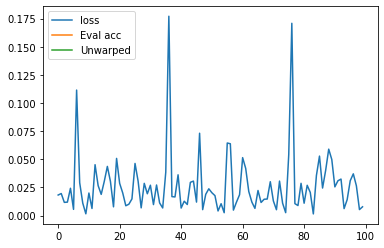

In [11]:
# Save Plots
plt.plot(np.arange(len(losses)), losses, label='loss')
plt.plot(np.arange(len(accs)), accs, label='Eval acc')
plt.plot(np.arange(len(unwapred)), unwapred, label='Unwarped')
plt.legend()
plt.savefig("plots/100-Epochs-refactored.png")

# I am still investigating why the loss looks that way. Have not found a clue as of now...

In [ ]:
update_sheet(epochs, optimizer, 'label loss + diffloss',grad_accum,lr, mode, eval_mean_dice, unwarped_dice, 'eighted Loss')

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

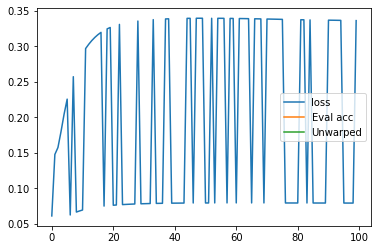

In [55]:
plt.plot(np.arange(len(losses)), losses, label='loss')
plt.plot(np.arange(len(accs)), accs, label='Eval acc')
plt.plot(np.arange(len(unwapred)), unwapred, label='Unwarped')
plt.legend()
#plt.savefig(f'plots/obel_16_1500E_{now}.png')

In [37]:
eval_mean_dice, unwarped_dice = evaluate_model(obel)

In [38]:
print(eval_mean_dice)
unwarped_dice

tensor(0.6575)


tensor(0.5128)

In [28]:
update_sheet(epochs, optimizer, 'label loss + diffloss',grad_accum,lr, mode, eval_mean_dice, unwarped_dice, 'eighted Loss')

updated


In [39]:
torch.save(obel.state_dict(), f"models/Experiment_1/seq_16_mix_{now}.pth")

In [40]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

tensor(59)
tensor([0.3890, 0.1502]) VS unwarped tensor([0.4182, 0.2306])


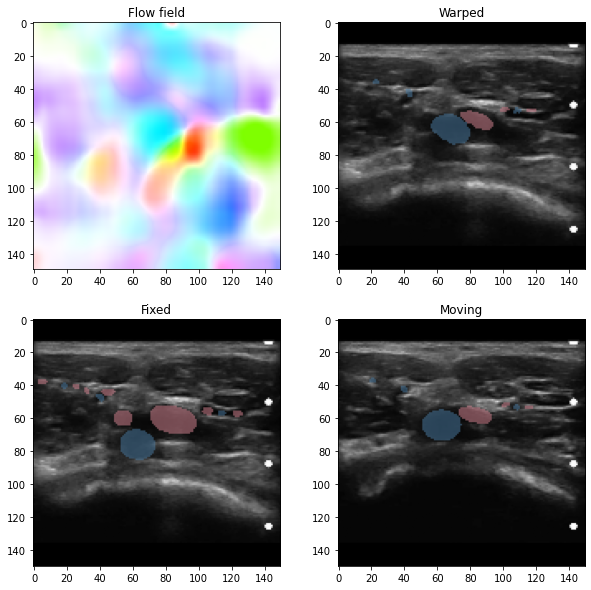

In [50]:
# Check if the flow actually looks ok and does what it is supposed to
# The Loss is usually not enough.
obel.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
print(rnd_test_idx[0])

fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous()
moving_seg = segs[p_fix:p_fix+1,1,:].contiguous()

# quick fix here...
if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
    fixed_seg = fixed_seg*2
if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
    moving_seg = moving_seg*2


with torch.no_grad():
    fixed_feat = obel(fixed.cuda())
    moving_feat = obel(moving.cuda())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4 +1, W//4 +1)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')

#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.flip(1).permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),3)
d0 = dice_coeff(fixed_seg,moving_seg,3)

print(f"{d1} VS unwarped {d0}")

rgb = showFlow(dense_flow_fit.flip(1).cpu().transpose(-2,-1).flip(1))
overlay = overlaySegment(fixed.squeeze(),warped_student_seg.data.squeeze(),False)

overlay_fixed = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),False)
overlay_moving = overlaySegment(moving.squeeze(),moving_seg.data.squeeze(),False)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb)
plt.title("Flow field")
plt.subplot(222)
plt.imshow(overlay)
plt.title("Warped")

plt.subplot(223)
plt.imshow(overlay_fixed)
plt.title('Fixed')
plt.subplot(224)
plt.imshow(overlay_moving)
plt.title("Moving")
plt.show()

In [38]:
now = datetime.datetime.now().strftime("%d_%m_%y-%H-%M")

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
torch.save(obel.state_dict(), f"models/Experiment_1/obel16_oneFixed_{now}.pth")

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

# Sequential

In [ ]:
seq = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=0,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,24,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())
seq.train().cuda()
optimizer = torch.optim.Adam(list(seq.parameters()),lr=lr)

In [ ]:
losses = []
accs = []
for epoch in tqdm(range(epochs)):

    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for i,rnd_idx in enumerate(rnd_train_idx):
        loss_tmp = []
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].contiguous()

        # Downsize the label
        C1,Hf,Wf = moving_seg.size()
        label_moving = F.one_hot(moving_seg.long(),num_classes=2).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving,size=(Hf//4,Wf//4),mode='bicubic')
        
        label_fixed = F.one_hot(fixed_seg.long(),num_classes=2).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bicubic')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,2,displace_range**2,-1)

        # passed through obelisk layer
        feat00 = seq(fixed.cuda())      # fixed
        feat50 = seq(moving.cuda())     # moving

         # compute the cost tensor using the correlation layer
        ssd_distance = correlation_layer(displace_range, feat50, feat00)

        # compute the MIN-convolution & probabilistic output with the given function
        soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
        
        label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)

        label_distance1 = torch.sum(torch.pow(label_fixed.reshape(2,-1)-label_warped.reshape(2,-1),2),0)
        loss = label_distance1.mean()
        # perform the backpropagation and weight updates
        loss.backward()
        loss_tmp.append(loss.item())
    losses.append(np.mean(loss_tmp))
    acc, _ = evaluate_model(obel)
    accs.append(acc)
    #diffs.append(loss.item())
    if (epoch+1)%grad_accum == 0:
        # every grad_accum iterations :Make an optimizer step
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
plt.plot(np.arange(len(losses)), losses, label='loss')
plt.plot(np.arange(len(accs)), accs, label='Eval acc')
plt.legend()

In [ ]:
eval_mean_dice, unwarped_dice = evaluate_model(seq)
print(eval_mean_dice)
unwarped_dice

In [ ]:
update_sheet(epochs, optimizer, 'Sequentail label loss',grad_accum,lr, mode, eval_mean_dice, unwarped_dice)

In [ ]:
seq.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]

fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

fixed_seg = segs[p_fix:p_fix+1,0,:].contiguous()
moving_seg = segs[p_fix:p_fix+1,1,:].contiguous()

# quick fix here...
if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 2:
    fixed_seg = fixed_seg*2
if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 2:
    moving_seg = moving_seg*2

with torch.no_grad():
    fixed_feat = obel(fixed.cuda())
    moving_feat = obel(moving.cuda())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),2)
d0 = dice_coeff(fixed_seg,moving_seg,2)

rgb = showFlow(dense_flow_fit.cpu().transpose(-2,-1).flip(1))
overlay = overlaySegment(fixed.squeeze(),warped_student_seg.data.squeeze(),False)

overlay_fixed = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),False)
overlay_moving = overlaySegment(moving.squeeze(),moving_seg.data.squeeze(),False)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb)
plt.subplot(222)
plt.imshow(overlay)

plt.subplot(223)
plt.imshow(overlay_fixed)
plt.subplot(224)
plt.imshow(overlay_moving)

In [ ]:
torch.save(seq.state_dict(), "models/Experiment_1/seq_24_500.pth")

# Comparisson


In [ ]:
print("Obelisk:")
evaluate_model(obel)
print("Sequential:")
evaluate_model(seq)

In [ ]:
torch.save(obel.state_dict(), "models/obel_solo_24.pth")
torch.save(seq.state_dict(), "models/seq_solo_24.pth")

## Baseline

In [ ]:
baseline = cv2.optflow.DualTVL1OpticalFlow_create()
overall_dice = []

for i,idx in enumerate(test_set):
        
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].contiguous()
        moving_seg = segs[idx:idx+1,1,:].contiguous()
        
        # Some images have no segmentation to them, 
        # even if it was present in the directory
        # We leave these ones out, as they cannot be avaluated
        
        # quick fix here...
        if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 2:
            fixed_seg = fixed_seg*2
        if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 2:
            moving_seg = moving_seg*2
        if fixed_seg.max() < 0.1 and moving_seg.max() < 0.1:
            pass
        else:
            in1 = fixed.view(H,W,1).numpy().astype(np.float32)
            in2 = moving.view(H,W,1).numpy().astype(np.float32)
            flow = baseline.calc(in1,in2,None)
            
            torch_flow = torch.from_numpy(flow).unsqueeze(0)
            B, C, H, W = torch_flow.permute(0,3,1,2).size()
            # mesh grid
            xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
            yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
            xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
            yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
            grid = torch.cat((xx, yy), 1).float()

            vgrid = grid + torch_flow.permute(0,3,1,2)

            # scale grid to [-1,1]
            vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
            vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

            vgrid = vgrid.permute(0, 2, 3, 1)
            warped_seg = nn.functional.grid_sample(moving_seg.float().unsqueeze(0), vgrid)
            #warped_seg = warpImage(moving_seg.view(1,1,H,W).float(), torch.from_numpy(flow).view(1,2,H,W))
            #warped_seg = warp(moving_seg.float().unsqueeze(0).cuda(), torch.from_numpy(flow).view(2,H,W).unsqueeze(0).cuda()).cpu().to(torch.int64)
            
            overall_dice.append(dice_coeff(fixed_seg,warped_seg.squeeze(),2).mean())
overall_dice = torch.from_numpy(np.array(overall_dice))
print(f"Baseline reached a mean dice score of {round(overall_dice.mean().item(),5)} with Var of {round(overall_dice.var().item(),5)}")

# Results
Over 100 epochs, with lr=0.0002

|Model|Mean Dice|Dice Var| Epochs | Learning Rate|
| --- | --- | --- |--- | --- |
|*Unwarped*|*0.7478*|*0.04863*| - | -|
|Baseline|0.73016|0.04262| - | - |
|**Obelisk** |**0.87912**|**0.01592**|100 | 0.0002|
|Sequential|0.82724|0.0174| 100  | 0.0002|

over 50 epochs with lr=0.0002

|Model|Mean Dice|Dice Var| Epochs | Learning Rate|
| --- | --- | --- |--- | --- |
|*Unwarped*|*0.7478*|*0.04863*| - | -|
|Baseline|0.73016|0.04262| - | - |
|**Obelisk** |**0.85881**|**0.01835**|50 | 0.0002|
|Sequential|0.79939|0.02399| 50  | 0.0002|

over 50 epochs with lr = 0.0005

|Model|Mean Dice|Dice Var| Epochs | Learning Rate|
| --- | --- | --- |--- | --- |
|*Unwarped*|*0.7478*|*0.04863*| - | -|
|Baseline|0.73016|0.04262| - | - |
|**Obelisk** |**0.8419**|**0.03165**|50 | 0.0005|
|Sequential|0.82078|0.01824| 50  | 0.0005|

# Verdcit
Over every run, with an adam optimizer the Obelisk feature extractor outperforms the sequential model (Both with 24 feature channels), when looking at the mean dice score and dice score variance. This is why we will consider the obelisk feature extractor from now on, as it seems to have an adjvantage over a simple sequential model, when it comes to processing Ultrasound images.

best choice so far would be to used lr=0.0002 and 100 epochs. This is why we stick with this setting for the rest of the experiments. In the end, if we have time, we will try to find an optimal setting and save the weights, to have a good predictor. Every model will be evaluated on the eval data in the end.


## Next
Next we will try to use a relatively simple student teacher approach, in order to give in more information to the feature extractor, which could lead to better performance.